## Quick Short Tour of FastAI Image Data Augmentations

Fastai is a deep learning library built on top of PyTorch. It has a goal of integrating/encapsulating the state of the art techniques in Deep Learning such that they are widely accessible, often in only a few lines of code.

In this tour, I will narrowly focus on its image data augmentation APIs. This is one of the more important tool for regularizing your net, especially if you don't very little data.

Prerequisites:

* Python 3.6 or above
* fastai 1.0.42 
* matplotlib 3.0.2 (may do with older)

#### Imports

In [1]:
from pathlib import *

from fastai.vision import *
from fastai.collab import *
from fastai.tabular import *

from fastai.metrics import error_rate

%load_ext autoreload
%autoreload 2

#import matplotlib.pyplot as plt
#%matplotlib inline

#### Setting up our simple template image

Current directory of this notebook has a folder called 'samples'.
Inside this folder, there is a "train" subfolder that holds the sample image.

We do this so we can use ImageDataBunch.from_folder(...), which will look
for images in a subfolder named 'train'.

In [2]:
path = Path('samples')

Construct an absolute bare bone ImageDataBunch with just 1 image and visualize it.

There are docs/tutorials that use real photo. But I like to use a very simple geometry to highlight rotation, reflection, padding, perspective warp, etc. It may not be ideal for brightness and color test, you can subtitute your own favorite.

/Users/kelvinchan/tmp/python3_env/deeplearning/lib/python3.7/site-packages/fastai/data_block.py:411: UserWarning: Your validation set is empty. Is this is by design, use `no_split()` 
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")


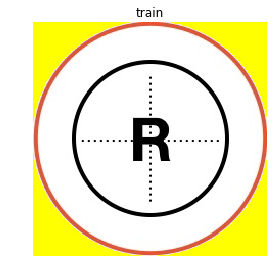

In [3]:
# This is the original image without any data augmentation

data = ImageDataBunch.from_folder(path, bs=1); data.show_batch()

We will set this "data bunch" aside for now, and instantiate an fastai.vision.image.Image to try out some transforms. We will come back to the "data bunch " later.

Fastai provided an open_image(...) method to do this.

In [4]:
filename = 'get_transforms.jpg'

def get_sample_image():                 # we want to call this to see effect of a transform(s) on the original image
    return open_image(path/'train'/filename)   # this returns an fastai.vision.image.Image

#### Taking a quick look at fastai's default data augmentation

Lets take a look at what fastai default will give us. This is generated by the helper method:

    get_transforms(...)

Details here:

* https://docs.fast.ai/vision.transform.html#get_transforms

* https://github.com/fastai/fastai/blob/master/fastai/vision/transform.py#L293

for the arguments it takes and what they do. We will visualize them here.

In [5]:
# Configure plotting params.
rows, cols, width, height = 2, 4, 12, 6    # adjust this if you want to show more and/or bigger figure size.

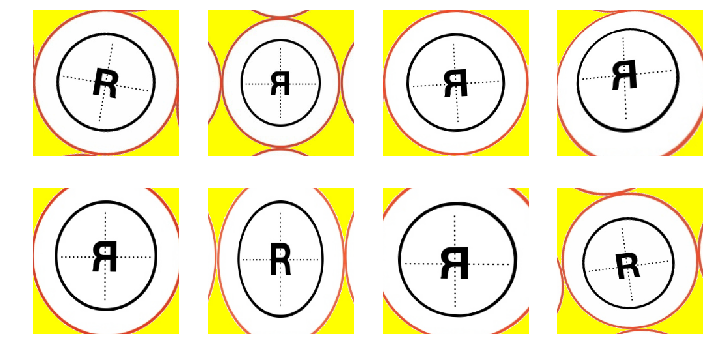

In [6]:
# ds_tfms declared a set of transforms. Most of these transforms have values (or ranges of) and the concrete ones
# will be picked at random with probaility p_affine (and/or p_lighting).
# To illustrate this, you want to run this cell a few times to generate a variety of samples to 
# get a feel of what they do.

ds_tfms = get_transforms()    # use all defaults without modification, this is a tuple (one for train, one for validation)

[get_sample_image().apply_tfms(ds_tfms[0], size=224).show(ax=ax) 
 for i, ax in enumerate(plt.subplots(rows, cols, figsize = (width, height))[1].flatten())
];

You can identify left/right mirror flip, zooming, rotation, etc. The default method for padding is 'reflect' which you can clearly see happening to some of the images at the boundary. One interesting transform is warping. This "perspective warping" simulates looking down at an object at an angle. For lighting, this image may not be ideal, you can use your own photo.

**Coding Note**: ds_tfms[0] is used because get_transforms(...) returns a 2-tuple. The first is a list of transforms for the training set and the second one for validation. We are examining the training set data aug in the above cell.

**General Note**: It is important to take a look at how your images get transformed before training. Sometimes, the default may not be appropriate and can lead to worse performance. This will rely on your own intuition and domain expertise. 

#### Configuring your own transforms

Fastai folks recommended the default get_transforms(...) or by tweaking its parameters will cover a lot of cases.
But if you need to configure a set of transforms from scratch, you can read this section.

Fastai provides lot of transforms. You can take a look at 

   https://docs.fast.ai/vision.transform.html

for all the details. I will select a few to illustrate how you can experiment with them on your own.

It is important to visualize a transform even after reading the code. Nothing is better than your own eyes and intuition to decide if the transform is appropriate.

Lets take a look at what *rotate* does, do the usual "??" and shift-enter to bring up the quick help.

In [ ]:
rotate??

Rotate has an argument "degrees" which is argument type of uniform. You will need to provide a value or a range represented by a tuple from which a random value can be drawn. The call signature also listed out more params (e.g. p: float) its superclass can take (which implies rotate can also take). The "p" param states that this transform is to be applied for probability p. Also make a mental note of the return type, which is **TfmAffine**.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


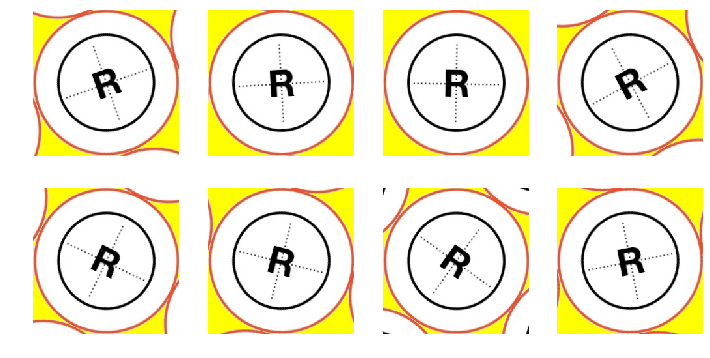

In [7]:
tfms = [rotate(degrees=(-45., 45.), p=0.9)]    # put this transform in a list 
# tfms = [rotate(degrees=45, p=0.9)]         # if you want it fixed at 45 degree

[get_sample_image().apply_tfms(tfms, size=224).show(ax=ax) 
 for i, ax in enumerate(plt.subplots(rows, cols, figsize = (width, height))[1].flatten())
];

So we have applied a rotation randomly picked from range -45 to 45 with a probability of 0.9 and ONLY that and nothing else, since we are configuring our own transform. Note that there are more params such as size=224 thats not part of tfms. This is a design choice fastai seemed to make. Conceptually, resizing is not considered to be a *dynamic* data augmentation transform by some. But you can argue it is if you think about the "multi-resolution" fine-tuning mentioned in fastai lesson.

Depending on your runs (run the above cell multiple times if needed), you may see the padding that is "reflect". This may be highly problematic if you work on "counting" task, or object localization. There are 2 other popular choices:

* zeros (just fill in with blackness)
* border (fill with same pixel at the edge of the image, or pixel continuation if you like.)

Padding is also not specified in tfms but in the same manner as size=224. Lets try them.

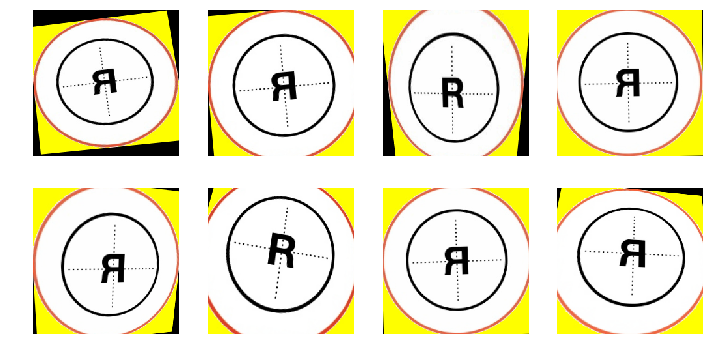

In [8]:
# Zero padding

# Due to an apparent bug, padding_mode doesnt seem to work with custom transform, but only the default get_transforms
# See https://github.com/fastai/fastai/issues/1681
# I will update this later when I get more clarifications

[get_sample_image().apply_tfms(tfms=get_transforms()[0], size=224, padding_mode='zeros').show(ax=ax) 
 for i, ax in enumerate(plt.subplots(rows, cols, figsize = (width, height))[1].flatten())
];

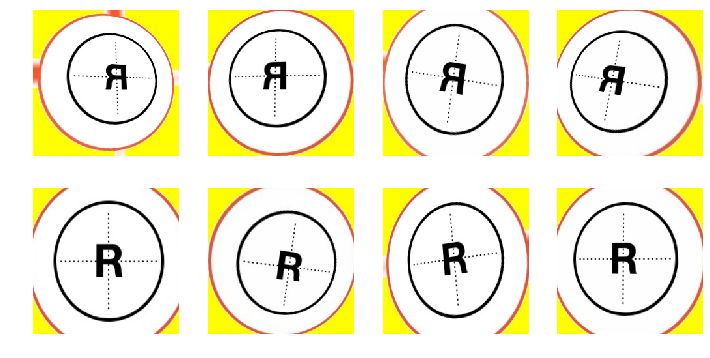

In [9]:
# Border padding
[get_sample_image().apply_tfms(tfms=get_transforms()[0], size=224, padding_mode='border').show(ax=ax) 
 for i, ax in enumerate(plt.subplots(rows, cols, figsize = (width, height))[1].flatten())
];

Lets try the transform *rand_resize_crop* , we will do it carelessly to provoke an error intentionally, and then work to fix it easily.

In [ ]:
rand_resize_crop??

In [10]:
tfm = rand_resize_crop(224, max_scale=1.5, ratios=(0.7, 1.2))

tfms.append(tfm)   # add this to the list of tfms (which has only rotate(...) so far).

In [12]:
# Add a single '#' in front of the first ''' to run this cell. A neat trick for toggling (un)comment for a block of code.

'''
[get_sample_image().apply_tfms(tfms, size=224, padding_mode='zeros').show(ax=ax) 
  for i, ax in enumerate(plt.subplots(rows, cols, figsize = (width, height))[1].flatten())
 ];
#''';

What is happening?? This is the 1st error we encountered in this tour. If you go back to look at the ?? help for this transform, you will notice the return type is not a transform, it is a list of transforms. This is actually great. It is hinting you transformation can be composed. Take a look at tfms

In [13]:
tfms

[RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-45.0, 45.0)}, p=0.9, resolved={'degrees': 10.940141775638317}, do_run=True, is_random=True),
 [RandTransform(tfm=TfmCoord (zoom_squish), kwargs={'scale': (1.0, 1.5, 8), 'squish': (0.7, 1.2, 8), 'invert': (0.5, 8), 'row_pct': (0.0, 1.0), 'col_pct': (0.0, 1.0)}, p=1.0, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmPixel (crop), kwargs={'size': 224}, p=1.0, resolved={}, do_run=True, is_random=True)]]

We have a list of list here. This is not what apply_tfms(...) likes. We need to drop the last tfm and redo this correctly.

In [14]:
tfms = tfms[0:1]  # keep only 1st tfm in the list
tfms.extend(tfm)  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


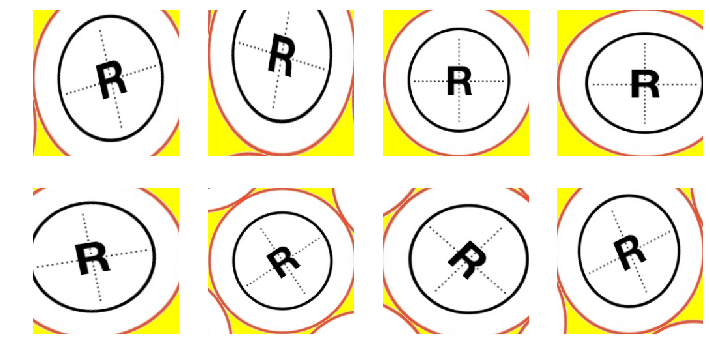

In [15]:
[get_sample_image().apply_tfms(tfms, size=224, padding_mode='zeros').show(ax=ax) 
 for i, ax in enumerate(plt.subplots(rows, cols, figsize = (width, height))[1].flatten())
];

So next time, just check if we are dealing with a transform thats made of a list of more elementary transforms, and be sure to construct tfms (our list of transform) correctly.

Finally, lets try *brightness*

In [ ]:
brightness??

Again, not the "change" param has keyword "uniform", so we guess it is a range represented by a tuple. If you specify only 1 number in the tuple, it will use that value, otherwise, it is interpreted as a range.

In [16]:
brightness_tfm = brightness(change=(0.1), p=1.0)
tfms.append(brightness_tfm)

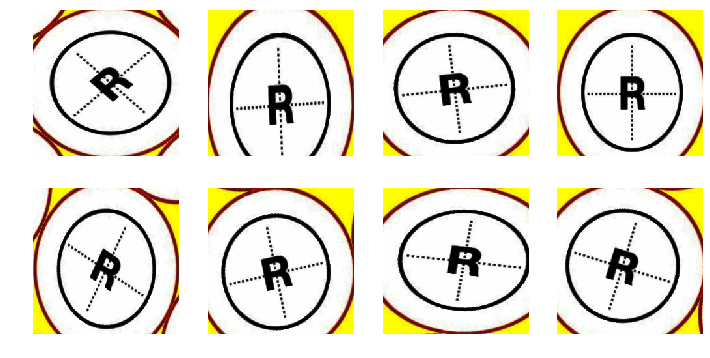

In [17]:
[get_sample_image().apply_tfms(tfms, size=224, padding_mode='zeros').show(ax=ax) 
 for i, ax in enumerate(plt.subplots(rows, cols, figsize = (width, height))[1].flatten())
];

In [18]:
tfms = tfms[:-1]   # drop the prior brightness transform

In [19]:
brightness_tfm = brightness(change=(0.95), p=1.0)
tfms.append(brightness_tfm)

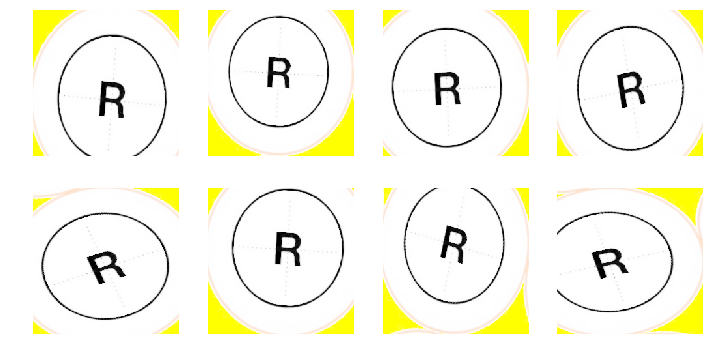

In [20]:
[get_sample_image().apply_tfms(tfms, size=224, padding_mode='zeros').show(ax=ax) 
 for i, ax in enumerate(plt.subplots(rows, cols, figsize = (width, height))[1].flatten())
];

It maybe better to have a real photo for this test. Try with the cat photo in the fastai doc. 

So you can keep growing this list of transforms as your task requires and visualize them. And if you hit an error that looks like the one we highlighted, try use .extend(). And for param that has "uniform" in the type, it usually want a tuple and try to go back to the doc to see what the default ranges are.

Finally, let use our tfms and try to put it in our data bunch. Data bunch expects a tuple consists of 2 list of transforms. One for training and another for validation. If you want to use the default transform for the validation set, you can extract what's given to you in get_transforms(...) and construct your new tuple using our own tfms for training part.

In [21]:
ds_tfms = get_transforms()   # get the default again, ds_tfms is a tuple. First item is for train, 2nd for validation

validation_tfms = ds_tfms[1]   # grab the 2nd tfm, and use it for our validation

ds_tfms = (tfms, validation_tfms)  # construct a new ds_tfms with our own tfms for training part.

**Warnng: if you hit an error DataLoader is killed for the below cell, try put num_workers=0 as a param for .from_folder(...)**

/Users/kelvinchan/tmp/python3_env/deeplearning/lib/python3.7/site-packages/fastai/data_block.py:411: UserWarning: Your validation set is empty. Is this is by design, use `no_split()` 
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")


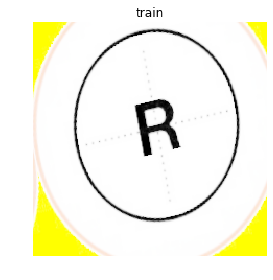

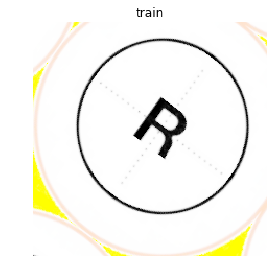

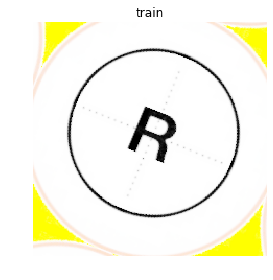

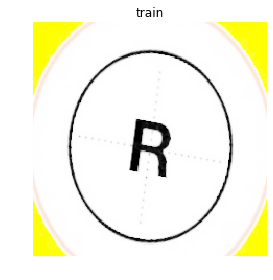

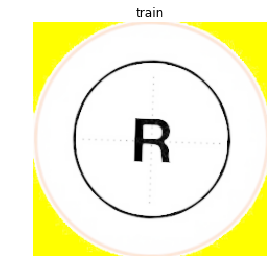

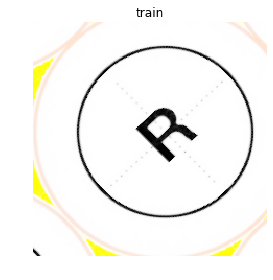

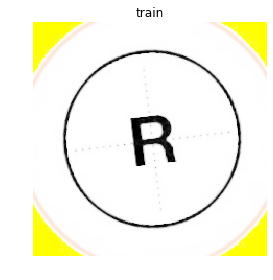

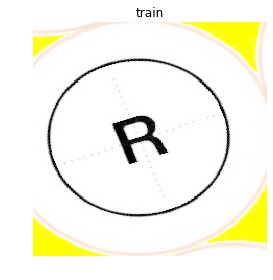

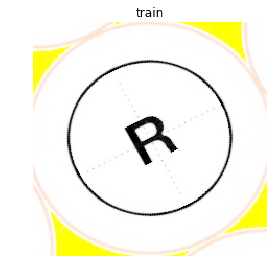

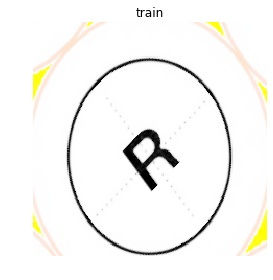

In [22]:
data = ImageDataBunch.from_folder(path, ds_tfms=ds_tfms, size=224, padding_mode='zeros', bs=1, num_workers=0)

for i in range(10):
    data.show_batch()

#### How to add a new affine tranform not available in fastai

It is useful to browse fastai/vision/transform.py to see how image transforms are done. Find the one that is closest to the one you would like to add, and use that as a guide to write your own. We will present two examples here: rot90_affine(...) and gaussian_blur(...)

##### rot90

If you look at the source for dihedral(or affine), you will note that this transform will randomly result in 8 different discrete orientation that are reflections and rotations. Let say you would like a new transform thats like np.rot90(...) A discrete rotation only transform resulting in 0, 90, 180, 270. You can easily add your own. 

But first take a quick look at what dihedral does:

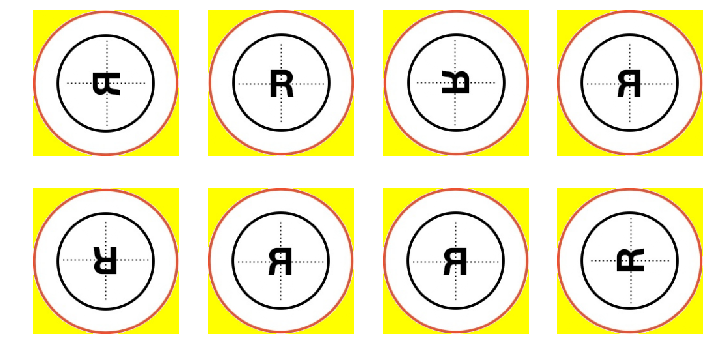

In [23]:
tfms = [dihedral_affine()]
[get_sample_image().apply_tfms(tfms, size=224, padding_mode='zeros').show(ax=ax) 
 for i, ax in enumerate(plt.subplots(rows, cols, figsize = (width, height))[1].flatten())
];

# fig, axs = plt.subplots(2,4,figsize=(12,8))
# for k, ax in enumerate(axs.flatten()):
#     dihedral_affine(sample_image, k+1).show(ax=ax, title=f'k={k+1}')
# plt.tight_layout()

This offers discrete rotation of 0, 90, 180, and 270 degrees plus reflection, resulting in 8 distinct transforms. 

Adding a new affine transform is relatively easy, here's how to do it:

1) Create a method with param k, which is the result of a random sampling of integer of 0 through 3 (including).

2) Instantiate a TfmAffine with the new method (a Callable). (TfmAffine is a subclass of Transform)

In [24]:
def _rot90_affine(k:partial(uniform_int, 0, 3)):
# def _rot90_affine(k):
    "Randomly rotate `x` image based on `k` as in np.rot90"
    #print("k={}".format(k))
    if k%2 == 0:
        x = -1. if k&2 else 1.
        y = -1. if k&2 else 1.
        
        return [[x, 0, 0.],
                [0, y, 0],
                [0, 0, 1.]]
    else:
        x = 1. if k&2 else -1.
        y = -1. if k&2 else 1.
        
        return [[0, x, 0.],
                [y, 0, 0],
                [0, 0, 1.]]

rot90_affine = TfmAffine(_rot90_affine)

Then, rot90_affine can be used just like any other tfm.

**Note: rot90_affine may already be available in fastai by the time you read this, please check before defining a new one.**

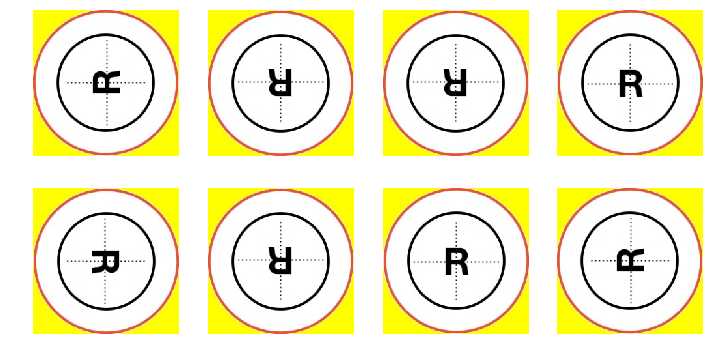

In [25]:
tfms = [rot90_affine()]
[get_sample_image().apply_tfms(tfms, size=224, padding_mode='zeros').show(ax=ax) 
 for i, ax in enumerate(plt.subplots(rows, cols, figsize = (width, height))[1].flatten())
];

Here's the version for TfmPixel

In [26]:
def _rot90(x, k:partial(uniform_int,0,3)):
    "Randomly flip `x` image based on `k` as in np.rot90"
#     print("k={}".format(k))
    if k == 1:
        x = torch.flip(x, [2])
        x = x.transpose(1, 2)
    elif k == 2:
        x = torch.flip(x, [2, 1])
    elif k == 3:
        x = torch.flip(x, [1])
        x = x.transpose(1, 2)
    
    return x.contiguous()
    
rot90 = TfmPixel(_rot90)


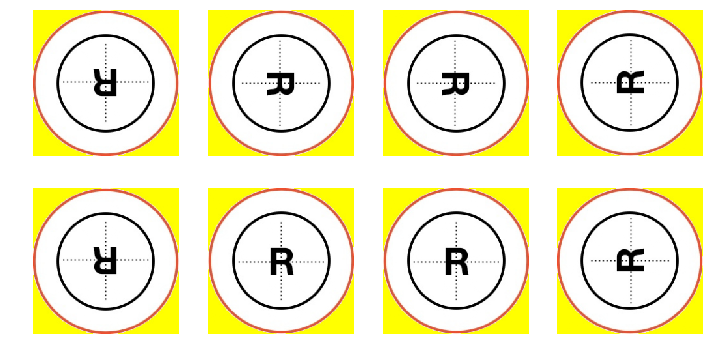

In [27]:
tfms = [rot90()]
[get_sample_image().apply_tfms(tfms, size=224, padding_mode='zeros').show(ax=ax) 
 for i, ax in enumerate(plt.subplots(rows, cols, figsize = (width, height))[1].flatten())
];

##### Gaussian blur
We will use PIL ImageFilter's Gaussian Blur. Since this library works with numpy, we have to add quite a bit of conversions. This snippet shows it is not difficult to add a new image transform and we can easily leverage from popular python modules such as PIL. However, you may want to do this more efficiently, you will have to reimplement this as a kernel operation in pytorch working directly with torch tensor (without going through numpy).

**Note: I may revise this to be better in near future. You can check for update on twitter @kelvindotchan.**

In [28]:
import PIL
from PIL import ImageFilter

def _gaussian_blur(x, radius:uniform):
#     print(radius)
    y = (x.numpy()*255.).astype(np.uint8).transpose((1, 2, 0))
    img = PIL.Image.fromarray(y)
    img = img.filter(ImageFilter.GaussianBlur(radius=radius))
    x = np.array(img).transpose((2, 0, 1))
    
    return torch.tensor(x/255., dtype=torch.float32)

gaussian_blur = TfmPixel(_gaussian_blur)

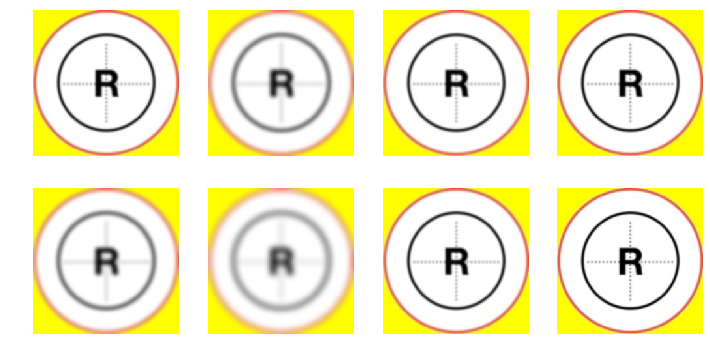

In [29]:
tfms = [gaussian_blur(radius=(0.5, 5.0))]
[get_sample_image().apply_tfms(tfms, size=224, padding_mode='zeros').show(ax=ax) 
 for i, ax in enumerate(plt.subplots(rows, cols, figsize = (width, height))[1].flatten())
];

/Users/kelvinchan/tmp/python3_env/deeplearning/lib/python3.7/site-packages/fastai/data_block.py:411: UserWarning: Your validation set is empty. Is this is by design, use `no_split()` 
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")


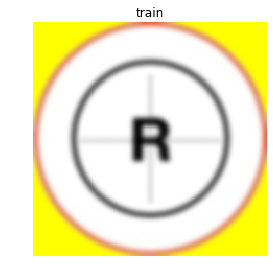

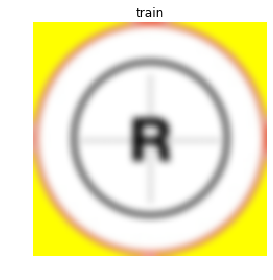

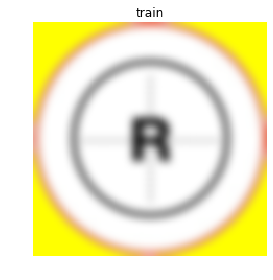

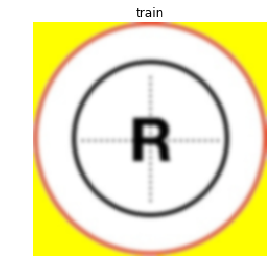

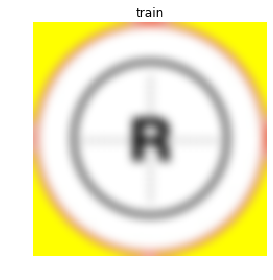

In [30]:
# test this out with data bunch
ds_tfms = get_transforms()   # get the default again, ds_tfms is a tuple. First item is for train, 2nd for validation
validation_tfms = ds_tfms[1]   # grab the 2nd tfm, and use it for our validation
ds_tfms = (tfms, validation_tfms)  # construct a new ds_tfms with our own tfms for training part.

data = ImageDataBunch.from_folder(path, ds_tfms=ds_tfms, size=224, padding_mode='zeros', bs=1, num_workers=0)

for i in range(5):
    data.show_batch()

### The End

That's it. Now you can use this ImageDataBunch to train your model. Please leave issues and comments in the git repos. 

I will either expand this notebook (or create a new one) to cover more in the near future. You can find me on Twitter **@kelvindotchan** where I will announce update.

**Thanks for reading.**